# Session 2: Training Models – Linear Regression and Beyond

**Introduction:**
So far we have treated Machine Learning models and their training algorithms mostly like black boxes. If you went through some of the exercises in the previous session, you may have been surprised by how much you can get done without knowing anything about what’s under the hood.

However, having a good understanding of how things work can help you quickly home in on the appropriate model, the right training algorithm to use, and a good set of hyperparameters for your task. Understanding what’s under the hood will also help you debug issues and perform error analysis more efficiently.

In this chapter we will start by looking at the **Linear Regression** model, one of the simplest models there is. We will discuss two very different ways to train it:

1. Using a direct “closed-form” equation (the **Normal Equation**) that directly computes the model parameters that best fit the training set.
2. Using an iterative optimization approach called **Gradient Descent (GD)** that gradually tweaks the model parameters to minimize the cost function over the training set.

We will also discuss several variants of Gradient Descent (Batch, Mini-batch, and Stochastic GD) and introduce **Regularization** techniques to prevent overfitting.

----

## 1. Linear Regression Basics



### What Is Linear Regression?

**Linear Regression** models the relationship between a dependent variable $y$ and one or more independent variables $x$. It assumes that this relationship can be expressed as a linear function:

$$
\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n
$$

In this equation:

- $\hat{y}$ is the predicted value.
- $n$ is the number of features.
- $x_i$ is the $i$th feature value.
- $\theta_j$ is the $j$th model parameter (including the bias term $\theta_0$ and the feature weights $\theta_1$, $\theta_2$, $\dots$, $\theta_n$).

This can be written much more concisely using a vectorized form:

$$
\hat{y} = \theta^T x
$$

In this equation:
- $\theta$ is the model’s parameter vector, containing the bias term $\theta_0$ and the feature weights $\theta_1$ to $\theta_n$.
- $x$ is the instance’s feature vector, containing $x_0$ to $x_n$, with $x_0$ always equal to 1.
- $\theta \cdot x$ is the dot product of the vectors $\theta$ and $x$ (which is, of course, equal to the weighted sum).
- $h_\theta$ is the hypothesis function, using the model parameters $\theta$.

**Note on “Linear”:**
The model is linear in the parameters $\theta$. Even if we later include polynomial terms (e.g., $x^2$), the model remains linear with respect to $\theta$.

OK, that’s the Linear Regression model—but how do we train it? Recall that training a model means setting its parameters so that the model best fits the training set. For this purpose, we first need a measure of how well (or poorly) the model fits the training data. The most common performance measure of a regression model is the **Root Mean Square Error (RMSE)**. Therefore, to train a Linear Regression model, we need to find the value of $\theta$ that minimizes the RMSE. In practice, it is simpler to minimize the **Mean Squared Error (MSE)** than the RMSE, and it leads to the same result (because the value that minimizes a function also minimizes its square root).

### The Cost Function: Mean Squared Error (MSE)

We evaluate our model’s performance with the **Mean Squared Error (MSE)**:

$$
\text{MSE}(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left( \hat{y}^{(i)} - y^{(i)} \right)^2
$$

- $m$ is the number of training examples.
- $\hat{y}^{(i)}$ is the predicted value for the $i$th example.
- $y^{(i)}$ is the actual value.

**Why Square the Errors?**
Squaring avoids cancellation of positive and negative errors and emphasizes larger deviations.


### Code Example: Generating and Visualizing Synthetic Data


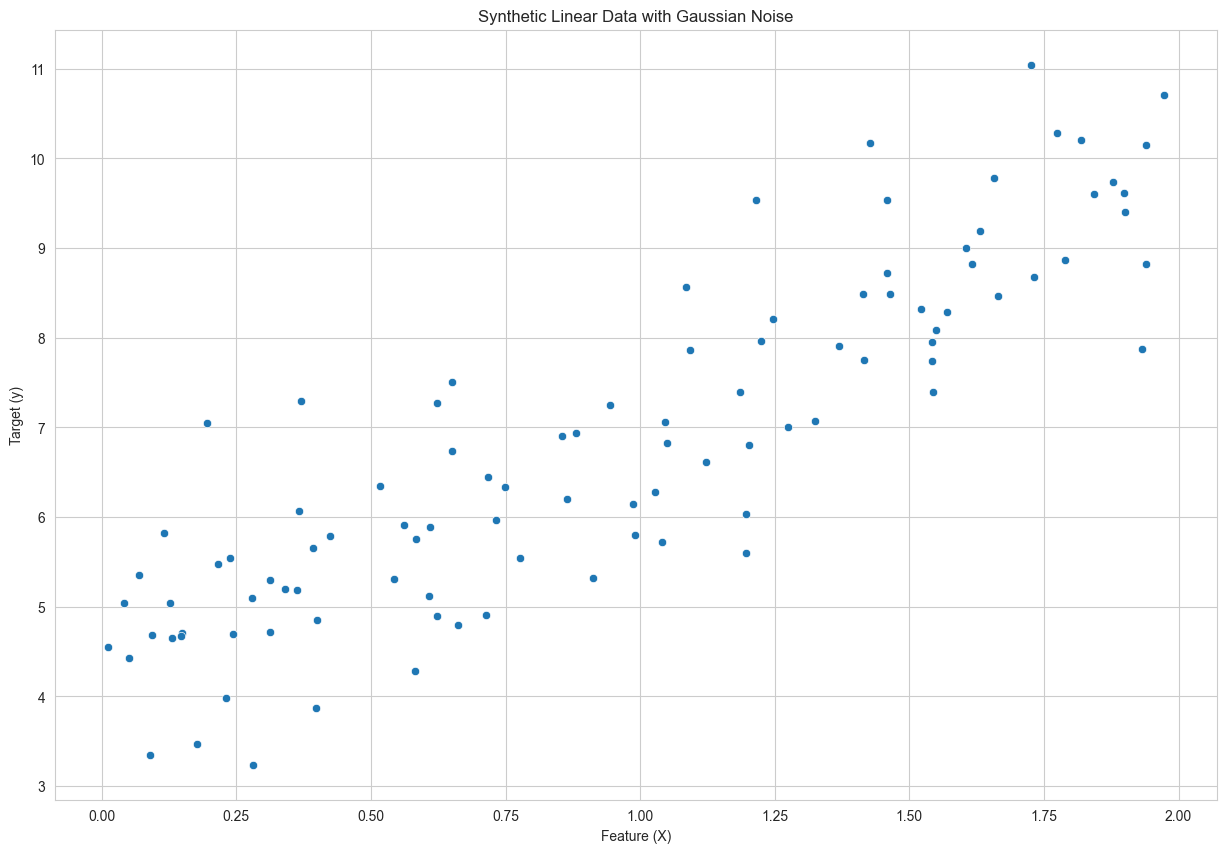

In [2]:
# Import necessary packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Generate synthetic data
m = 100  # number of samples
X = 2 * np.random.rand(m, 1)
# y = 4 + 3*X + noise, where noise is Gaussian (mean=0, std=1)
y = 4 + 3 * X + np.random.randn(m, 1)

# Create a DataFrame for plotting
data = pd.DataFrame({'X': X.flatten(), 'y': y.flatten()})

# Plot the data
plt.figure(figsize=(15, 10))
sns.scatterplot(x='X', y='y', data=data)
plt.xlabel('Feature (X)')
plt.ylabel('Target (y)')
plt.title('Synthetic Linear Data with Gaussian Noise')
plt.show()

*Explanation:*
- $X$ values are uniformly distributed between 0 and 2.
- $y$ is calculated as $4 + 3X$ plus Gaussian noise (added via `np.random.randn`).
- The resulting scatter plot shows data points that deviate slightly from the ideal line due to noise.
- **Gaussian noise** refers to random variations added to data that follow a normal distribution, characterized by a mean (typically 0) and a standard deviation.
- When we add Gaussian noise to synthetic data, we simulate real-world measurement errors or natural variability.
---

## 2. The Normal Equation

### What Is the Normal Equation?

The **Normal Equation** is a **closed-form solution** for linear regression. A closed-form solution is an expression that can be computed exactly in a finite number of operations—no iterations needed.

For linear regression, the Normal Equation is:

$$
\theta = \left( X^T X \right)^{-1} X^T y
$$

- $X$ is the matrix of input features (with an added column of ones for the intercept).
- $X^T$ is the transpose of $X$.
- $\left( X^T X \right)^{-1}$ is the inverse of $X^T X$.
- $y$ is the vector of target values.

**Derivation Insight:**
Starting from the MSE cost function, you set the gradient with respect to $\theta$ to zero and solve:

1. Write MSE:
   $$
   J(\theta) = \frac{1}{m}\sum_{i=1}^m (X^{(i)}\theta - y^{(i)})^2
   $$
2. Take the derivative with respect to $\theta$, set to zero:
   $$
   \nabla_\theta J(\theta) = \frac{2}{m} X^T (X\theta - y) = 0
   $$
3. Solve for $\theta$:
   $$
   X^T X\theta = X^T y \quad \Rightarrow \quad \theta = \left(X^T X\right)^{-1} X^T y
   $$

### When to Use the Normal Equation

- **Advantages:**
  - Direct computation of $\theta$ without needing to choose a learning rate.

- **Limitations:**
  - Computationally expensive for a large number of features (matrix inversion is $\mathcal{O}(n^3)$).
  - If $X^T X$ is singular (non-invertible), you need the [pseudoinverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse).

### Code Example: Applying the Normal Equation


In [3]:
# Add a column of ones to X for the intercept term
X_b = np.c_[np.ones((m, 1)), X]  # Shape becomes (100, 2)

# Compute the optimal theta using the normal equation
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
print("Optimal parameters (theta) computed using the Normal Equation:")
print(theta_best)

Optimal parameters (theta) computed using the Normal Equation:
[[4.21509616]
 [2.77011339]]


*Explanation:*
- We add a column of ones to include the intercept $\theta_0$.
- We compute $\theta$ using the formula, which should yield values close to $4$ (intercept) and $3$ (slope), subject to noise.



#### Plotting the Regression Line



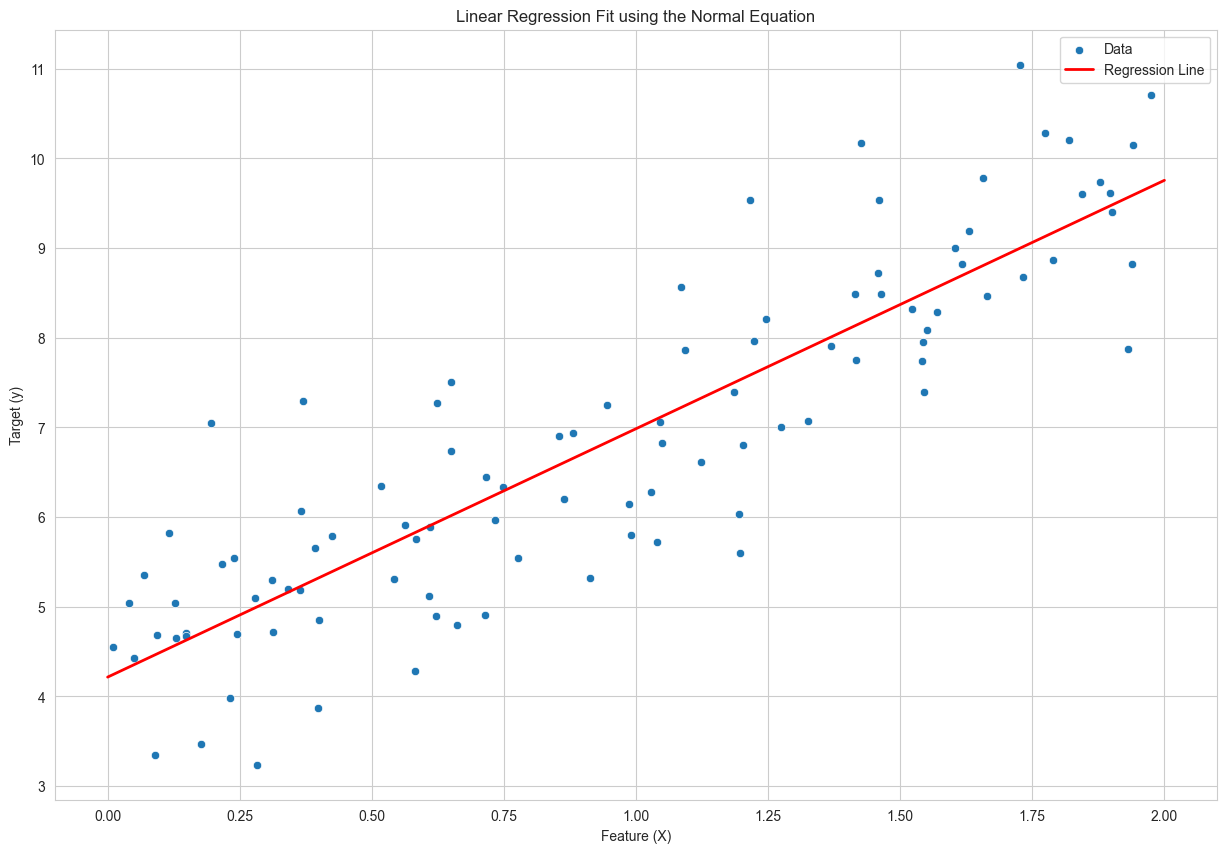

In [8]:
# Generate new X values for plotting the regression line
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)

# Plot the regression line with the original data
plt.figure(figsize=(15, 10))
sns.scatterplot(x='X', y='y', data=data, label='Data')
plt.plot(X_new, y_predict, "r-", linewidth=2, label='Regression Line')
plt.xlabel('Feature (X)')
plt.ylabel('Target (y)')
plt.title('Linear Regression Fit using the Normal Equation')
plt.legend()
plt.show()

*Explanation:*
- Two new $X$ values span the input range.
- Predictions are calculated using the optimal $\theta$.
- The red line is the fitted regression line overlaid on the data points.


---

**Discussion Question:**
*When might the normal equation become impractical, and what alternative could you use in that situation?*
*(Hint: Consider scenarios with a very large number of features.)*

---

## 3. Gradient Descent Variants

While the Normal Equation is elegant, it becomes impractical for very large datasets. **Gradient Descent** offers an iterative approach that can scale to large problems.

Gradient Descent is a generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of Gradient Descent is to tweak parameters iteratively in order to minimize a cost function.

Suppose you are lost in the mountains in a dense fog, and you can only feel the slope of the ground below your feet. A good strategy to get to the bottom of the valley quickly is to go downhill in the direction of the steepest slope. This is exactly what Gradient Descent does: it measures the local gradient of the error function with regard to the parameter vector θ, and it goes in the direction of descending gradient. Once the gradient is zero, you have reached a minimum!

Concretely, you start by filling θ with random values (this is called random initialization). Then you improve it gradually, taking one baby step at a time, each step attempting to decrease the cost function (e.g., the MSE), until the algorithm converges to a minimum.

An important parameter in Gradient Descent is the size of the steps, determined by the learning rate hyperparameter. If the learning rate is too small, then the algorithm will have to go through many iterations to converge, which will take a long time.

On the other hand, if the learning rate is too high, you might jump across the valley and end up on the other side, possibly even higher up than you were before. This might make the algorithm diverge, with larger and larger values, failing to find a good solution.

Fortunately, the MSE cost function for a Linear Regression model happens to be a **convex function**, which means that if you pick any two points on the curve, the line segment joining them never crosses the curve. This implies that there are **no local minima, just one global minimum**. It is also a continuous function with a slope that never changes abruptly.3 These two facts have a great consequence: Gradient Descent is guaranteed to approach arbitrarily close the global minimum (if you wait long enough and if the learning rate is not too high).

In fact, the cost function has the shape of a bowl, but it can be an elongated bowl if the features have very different scales.


### Interactive Visualization


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def gradient_descent_quadratic(lr=0.1, iterations=50):
    """
    Simulates gradient descent on the function f(x) = x^2.

    Parameters:
    - lr: learning rate (η)
    - iterations: number of gradient descent iterations
    """
    x0 = -6
    # Define the function f(x) = x^2 and its derivative f'(x) = 2x
    f = lambda x: x**2
    grad_f = lambda x: 2*x

    # Store the trajectory of x values
    x_values = [x0]
    x = x0
    for i in range(iterations):
        grad = grad_f(x)
        x = x - lr * grad
        x_values.append(x)

    # Create a range of x values for plotting the function
    x_range = np.linspace(-abs(x0)*1.5, abs(x0)*1.5, 400)
    y_range = f(x_range)

    # Plot the function and the descent trajectory
    plt.figure(figsize=(20, 10))
    plt.plot(x_range, y_range, label='$f(x) = x^2$', color='blue')
    # Plot the gradient descent steps
    descent_y = f(np.array(x_values))
    plt.plot(x_values, descent_y, 'ro-', label='Gradient Descent Steps')
    plt.xlabel('$x$')
    plt.ylabel('$f(x)$')
    plt.title('Gradient Descent on a U-shaped Function $f(x) = x^2$')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print the final value of x and f(x)
    print(f"Final x after {iterations} iterations: {x:.4f}")
    print(f"Final function value f(x): {f(x):.4f}")

# Create an interactive widget with sliders for learning rate, iterations, and initial x value
widgets.interact(gradient_descent_quadratic,
                 lr=(0.01, 1.0, 0.01),
                 iterations=(10, 100, 1));

interactive(children=(FloatSlider(value=0.1, description='lr', max=1.0, min=0.01, step=0.01), IntSlider(value=…

### Batch Gradient Descent

To implement Gradient Descent, you need to compute the gradient of the cost function with regard to each model parameter $θ_j$. In other words, you need to calculate how much the cost function will change if you change $θ_j$ just a little bit. This is called a partial derivative. It is like asking “What is the slope of the mountain under my feet if I face east?” and then asking the same question facing north (and so on for all other dimensions).

$$
\frac{\partial}{\partial \theta_j} MSE(\boldsymbol{\theta}) = \frac{2}{m} \sum_{i=1}^{m} \left( \boldsymbol{\theta}^{\top} \mathbf{x}^{(i)} - y^{(i)} \right) x_j^{(i)}
$$

Instead of computing these partial derivatives individually, you can compute them all in one go. The gradient vector, contains all the partial derivatives of the cost function (one for each model parameter):

$$
\nabla_{\boldsymbol{\theta}} MSE(\boldsymbol{\theta}) =
\begin{pmatrix}
\frac{\partial}{\partial \theta_0} MSE(\boldsymbol{\theta}) \\
\frac{\partial}{\partial \theta_1} MSE(\boldsymbol{\theta}) \\
\vdots \\
\frac{\partial}{\partial \theta_n} MSE(\boldsymbol{\theta})
\end{pmatrix}
= \frac{2}{m} \mathbf{X}^{\top} (\mathbf{X} \boldsymbol{\theta} - \mathbf{y})
$$


Once you have the gradient vector, which points uphill, just go in the opposite direction to go downhill. This means subtracting $\nabla_{\theta} \text{MSE}$ from $θ$. This is where the learning rate $η$ comes into play: multiply the gradient vector by $η$ to determine the size of the downhill step:

$$
\theta := \theta - \eta \cdot \nabla_{\theta} \text{MSE}
$$

- $\eta$ is the learning rate.
- $\nabla_{\theta} \text{MSE}$ is the gradient vector of the cost function.


#### Code Example: Batch Gradient Descent


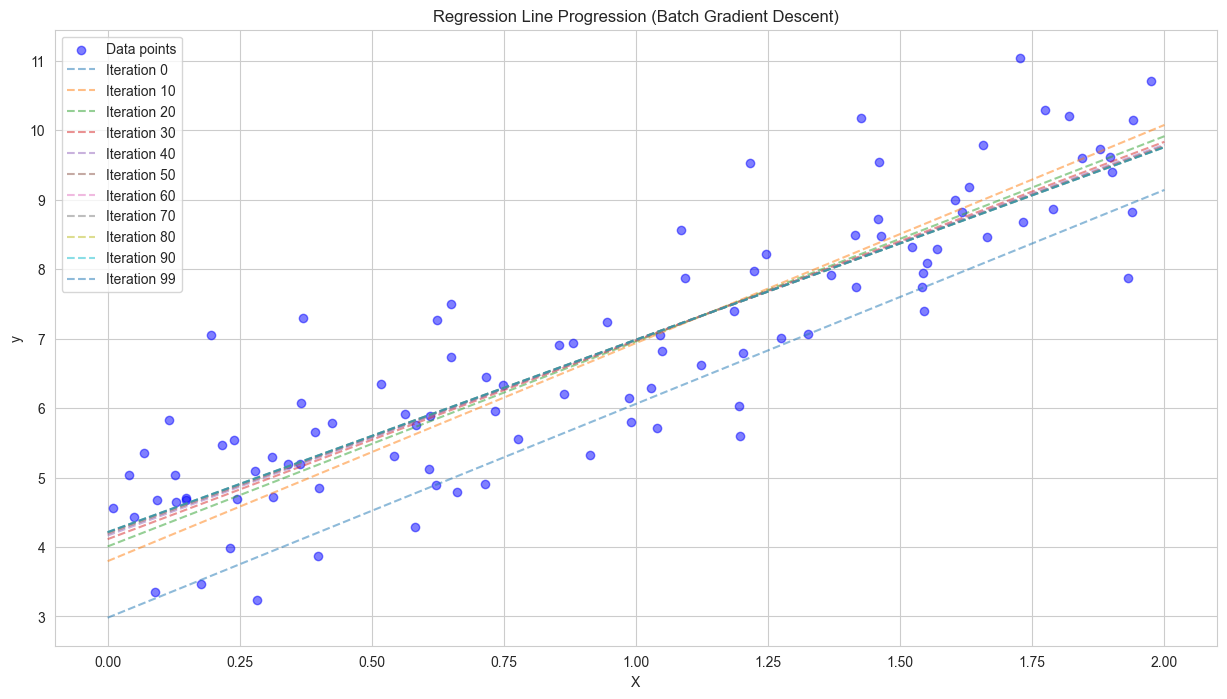

Theta computed using Batch Gradient Descent:
[[4.21429217]
 [2.77082327]]


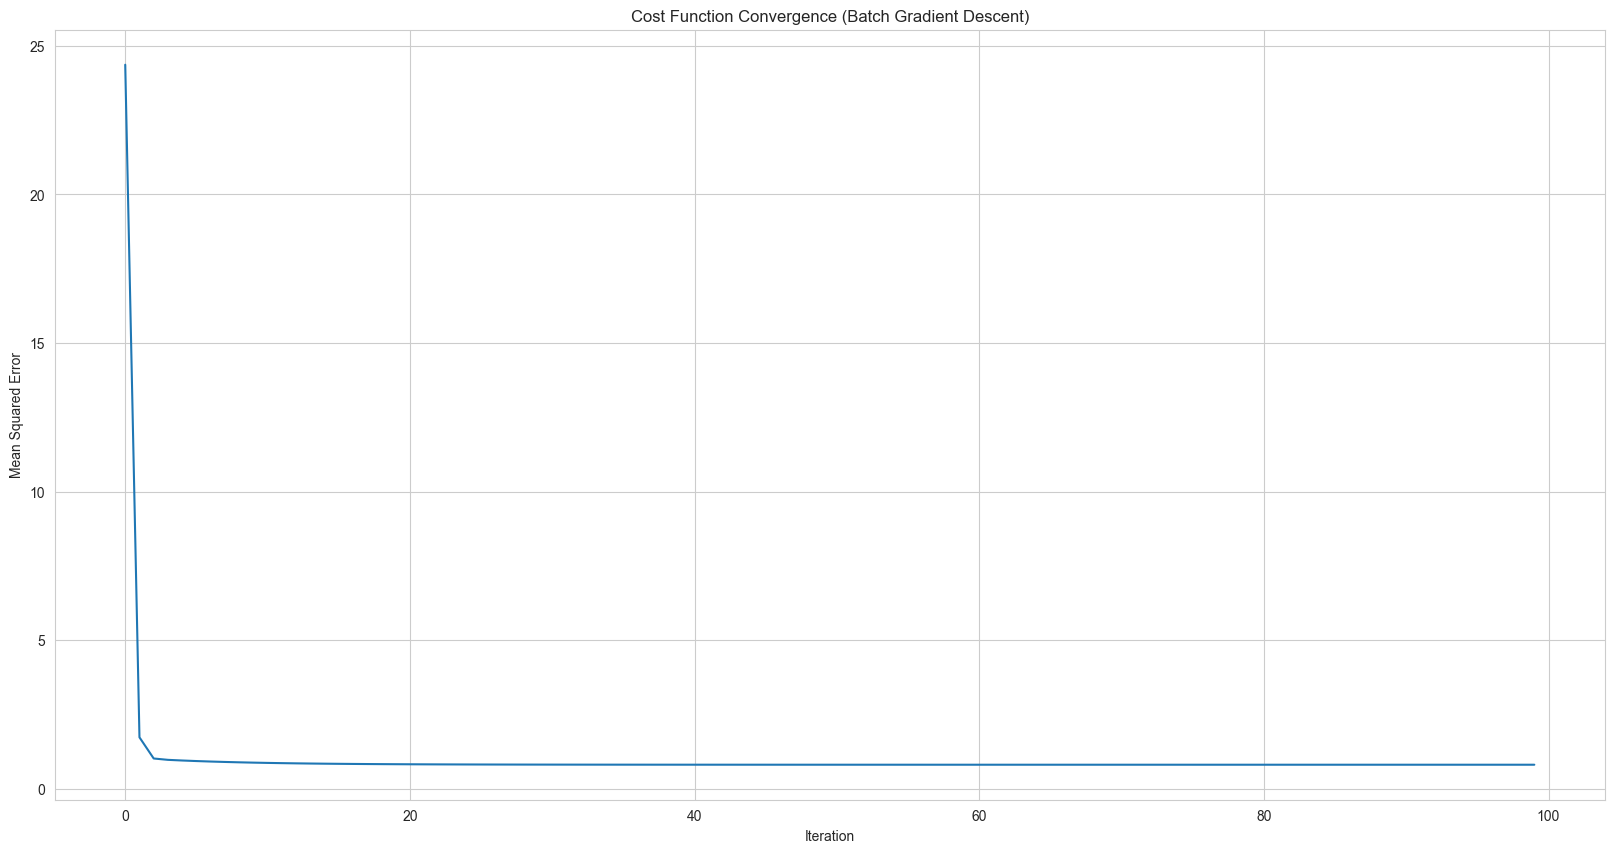

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize parameters randomly
theta = np.random.randn(2, 1)
eta = 0.2  # Learning rate
n_iterations = 100
costs = []  # To record MSE at each iteration

# Plot the data points
plt.figure(figsize=(15, 8))
plt.scatter(X, y, color='blue', label='Data points', alpha=0.5)

# Perform batch gradient descent
for iteration in range(n_iterations):
    predictions = X_b.dot(theta)
    cost = np.mean((predictions - y) ** 2)
    costs.append(cost)
    gradients = 2/m * X_b.T.dot(predictions - y)
    theta = theta - eta * gradients

    # Plot regression line at specific intervals
    if iteration % (n_iterations // 10) == 0 or iteration == n_iterations - 1:
        x_line = np.array([[0], [2]])  # Choose x-range for the line
        x_b_line = np.c_[np.ones((2, 1)), x_line]
        y_line = x_b_line.dot(theta)
        plt.plot(x_line, y_line, linestyle='dashed', alpha=0.5, label=f'Iteration {iteration}')

plt.xlabel("X")
plt.ylabel("y")
plt.title("Regression Line Progression (Batch Gradient Descent)")
plt.legend()
plt.show()

print("Theta computed using Batch Gradient Descent:")
print(theta)

# Plot cost convergence over iterations
plt.figure(figsize=(20, 10))
sns.lineplot(x=np.arange(n_iterations), y=costs)
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('Cost Function Convergence (Batch Gradient Descent)')
plt.show()

*Explanation:*
- We update $\theta$ in each iteration using the gradient computed over all training examples.
- The cost plot helps visualize convergence toward a minimum.

#### Brief Overview of Other Variants

- **Stochastic Gradient Descent (SGD):**
  Updates $\theta$ using one training example at a time. It converges faster on large datasets but introduces more noise.
- **Mini-Batch Gradient Descent:**
  Uses small batches of data to balance stability and speed.

---

**Discussion Question 3:**
*Do all Gradient Descent algorithms lead to the same model, provided you let them run long enough? What differences might you observe in practice?*
*(Hint: Think about the noise in updates and convergence speed differences.)*

---


## 4. Regularization Techniques


Regularization prevents overfitting by adding a penalty term to the cost function, discouraging overly complex models.

### Ridge Regression ($\ell_2$ Regularization)

Ridge Regression adds a penalty proportional to the square of the coefficients:

$$
\text{Cost} = \text{MSE} + \alpha \|w\|_2^2
$$

- $\alpha$ controls the penalty strength.
- $\|w\|_2^2 = \sum_{j=1}^n \theta_j^2$ (excluding $\theta_0$).

**Intuition:**
It “shrinks” the weights, reducing variance while keeping all features in the model.

### Lasso Regression ($\ell_1$ Regularization)

Lasso Regression adds a penalty proportional to the absolute values of the coefficients:

$$
\text{Cost} = \text{MSE} + \alpha \|w\|_1
$$

- $\|w\|_1 = \sum_{j=1}^n |\theta_j|$.
- It can drive some weights to zero, effectively performing feature selection.

### Elastic Net

Elastic Net combines both $\ell_1$ and $\ell_2$ penalties:

$$
\text{Cost} = \text{MSE} + \alpha \left( r \|w\|_1 + (1 - r) \|w\|_2^2 \right)
$$

- $r$ controls the mix between Lasso and Ridge.


#### Code Example: Polynomial Regression with Ridge Regularization


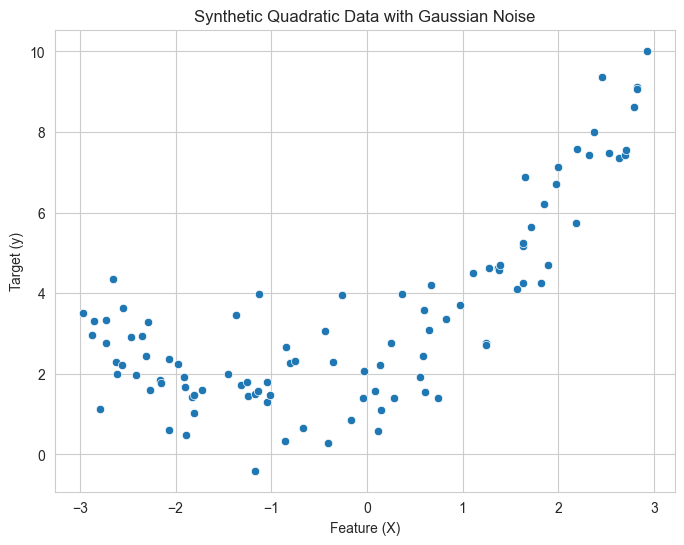

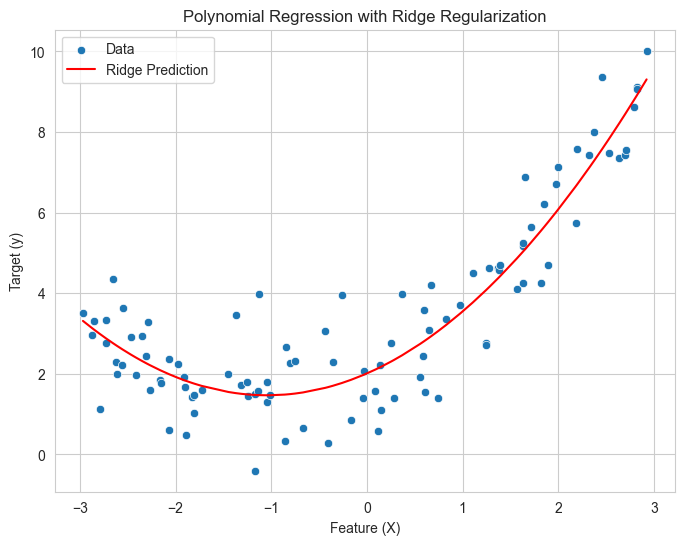

In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

# Generate synthetic quadratic data
np.random.seed(42)
X_poly = np.sort(6 * np.random.rand(100, 1) - 3, axis=0)
y_poly = 0.5 * X_poly**2 + X_poly + 2 + np.random.randn(100, 1)

# Plot the quadratic data
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_poly.flatten(), y=y_poly.flatten())
plt.xlabel('Feature (X)')
plt.ylabel('Target (y)')
plt.title('Synthetic Quadratic Data with Gaussian Noise')
plt.show()

# Create a pipeline: transform features to polynomial and then apply Ridge Regression
poly_ridge_model = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ("ridge_reg", Ridge(alpha=1))
])

# Fit the model and predict on the training data
poly_ridge_model.fit(X_poly, y_poly)
y_poly_pred = poly_ridge_model.predict(X_poly)

# Plot the predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_poly.flatten(), y=y_poly.flatten(), label='Data')
sns.lineplot(x=X_poly.flatten(), y=y_poly_pred.flatten(), color='red', label='Ridge Prediction')
plt.xlabel('Feature (X)')
plt.ylabel('Target (y)')
plt.title('Polynomial Regression with Ridge Regularization')
plt.legend()
plt.show()

*Explanation:*
- We generate quadratic data to illustrate a nonlinear relationship.
- A pipeline first creates polynomial features (degree 2) and then fits a Ridge Regression model.
- The red line shows the smoothed prediction, which regularization helps achieve by reducing overfitting.


---

**Discussion Question 4:**
*Suppose you are using Ridge Regression and you notice that both the training and validation errors are high and almost equal. Does this indicate high bias or high variance? How should you adjust the regularization parameter $\alpha$?*
*(Hint: High error on both suggests underfitting (high bias); consider reducing $\alpha$ or using a more complex model.)*

---

## 5. Assumptions, Limitations, and Debugging Tips

### Assumptions of Linear Regression
- **Linearity:** The relationship between input and output is linear.
- **Independence:** Observations are independent of one another.
- **Homoscedasticity:** Constant variance of errors.
- **Normality of Errors:** Errors are normally distributed (hence Gaussian noise is often assumed).

### Limitations
- **Multicollinearity:** When features are highly correlated, $X^T X$ can become singular.
- **Scalability:** The Normal Equation is impractical for high-dimensional data.
- **Overfitting:** Complex models may overfit, which is why regularization is essential.

### Debugging Tips
- **Learning Rate Issues:**
  If the cost oscillates or diverges, the learning rate may be too high.
- **Feature Scaling:**
  If gradient descent converges slowly, ensure features are normalized or standardized.
- **Learning Curves:**
  Plot training and validation errors to diagnose underfitting (high bias) versus overfitting (high variance).
- **Interactive Exploration:**
  Use interactive widgets to tweak parameters and observe how the model behavior changes.


## Wrap-Up

### Key Takeaways:
- **Linear Regression Basics:**
  Understand the model structure, cost function (MSE), and the role of Gaussian noise.
- **Normal Equation vs. Gradient Descent:**
  The Normal Equation provides a closed-form solution but is limited by scalability, while Gradient Descent is iterative and better suited for large datasets.
- **Gradient Descent Variants:**
  Batch, Stochastic, and Mini-Batch GD offer different trade-offs in convergence and computational efficiency.
- **Regularization:**
  Techniques such as Ridge, Lasso, and Elastic Net are critical for balancing bias and variance and preventing overfitting.
- **Assumptions and Debugging:**
  Understand the underlying assumptions of the model and use diagnostic plots and parameter tuning to address issues.

Feel free to experiment with the provided code, adjust hyperparameters using the interactive widgets, and explore further examples. These notes serve as both an introduction to the rigorous math behind training models and a hands-on guide for practical implementation.
